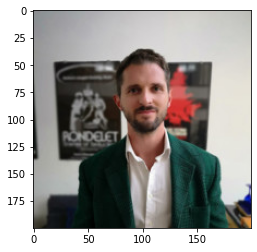

In [156]:
# Import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Load the image
data = plt.imread('images/me.jpg')

# Display the image
plt.imshow(data)
plt.show()

Check if image array data is writeable

In [157]:
data.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : False
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

If WRITEABLEis false, you _can_ change it with 
```python
data.setflags(write=1)
```
but better to take a copy:

In [158]:
data_cp = data.copy()

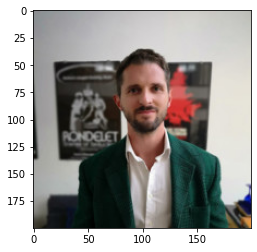

In [159]:
plt.imshow(data_cp)
plt.show()

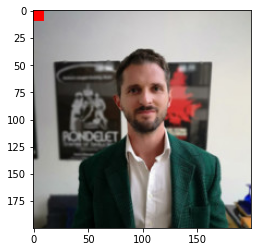

In [160]:
# Set the red channel in the top left 10 x 10 pixels  to 255
data_cp[:10, :10, 0] = 255

# Set the green channel in this part of the image to 0
data_cp[:10, :10, 1] = 0

# Set the blue channel in this part of the image to 0
data_cp[:10, :10, 2] = 0

# Visualize the result
plt.imshow(data_cp)
plt.show()

Next steps:
- convert train data into numpy array with following format:
In [3]:
train_data.shape
Out[3]:
(50, 28, 28, 1)
In [4]:
type(train_data)
Out[4]:
numpy.ndarray

Load 25 real and 25 fake images

In [161]:
def load_images_from_folder(folder, sample_size):
    images = []
    for filename in os.listdir(folder)[:sample_size]:
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

real_folder = 'images/crop_part1_real'
fake_folder = 'images/1m_faces_fake/1m_faces_sample'
sample_size = 30

real_images = load_images_from_folder(real_folder, sample_size)
fake_images = load_images_from_folder(fake_folder, sample_size)


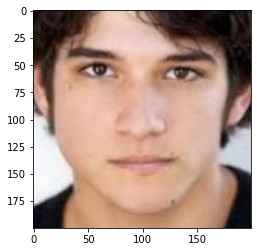

In [162]:
# OpenCV does not use RGB, it uses BGR (standing for blue, green, red).
# You need to swap the order of the red and the blue

def show_cv2_image(image):


    b,g,r = cv2.split(image)           # get b, g, r
    rgb_image = cv2.merge([r,g,b])     # switch it to r, g, b

    # Display the image
    plt.imshow(rgb_image)
    plt.show()
    
show_cv2_image(real_images[2])

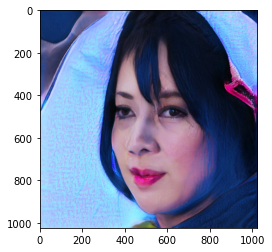

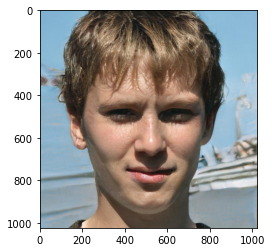

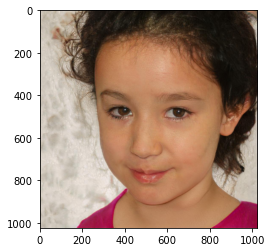

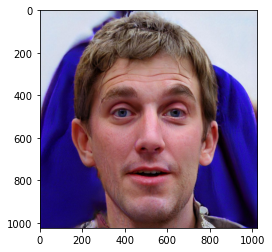

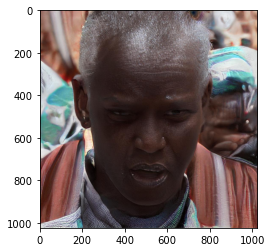

In [163]:
for i in range(5):
    show_cv2_image(fake_images[i])

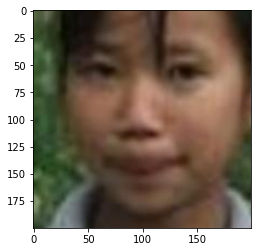

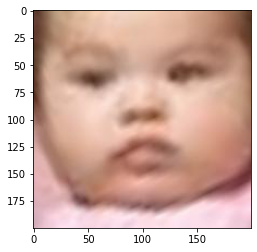

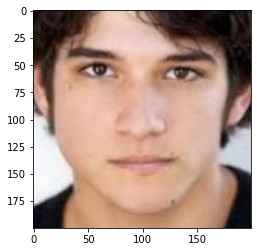

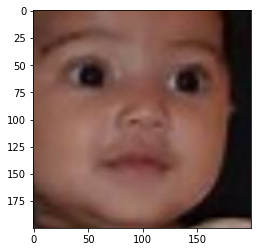

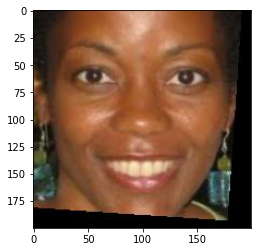

In [164]:
for i in range(5):
    show_cv2_image(real_images[i])

In [165]:
print("Dimensions of fake images are: {}".format(fake_images[0].shape))
print("Dimensions of real images are: {}".format(real_images[0].shape))

Dimensions of fake images are: (1024, 1024, 3)
Dimensions of real images are: (200, 200, 3)


Therefore we will rescale the dimensions of the fake images to be 200 x 200

Resize using cv2 fake images to have same shape as real (i.e. 200 x 200 pixels).
See this post on the different interpolation methods available in opencv for rescaling images: https://stackoverflow.com/questions/48121916/numpy-resize-rescale-image

I will use a cubic spline - interpolation=cv2.INTER_CUBIC - as used in the post.

In [166]:
def resize_image(image, dimensions):
    return cv2.resize(image, dsize=(dimensions[0], dimensions[1]), interpolation=cv2.INTER_CUBIC)

dimensions = [200,200]

#resize_image(fake_images[0], dimensions)

fake_images = [resize_image(image, dimensions) for image in fake_images]

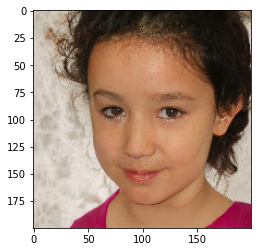

In [167]:
show_cv2_image(fake_images[2])

In [168]:
fake_images[2].shape

(200, 200, 3)

## Build Keras model

In [169]:
# Imports components from Keras
from keras.models import Sequential
from keras.layers import Dense

# Initializes a sequential model
model = Sequential()

# First layer
model.add(Dense(10, activation='relu', input_shape=(120000,)))

# Second layer
model.add(Dense(10, activation='relu'))

# Output layer
model.add(Dense(1, activation='softmax'))

In [170]:
# Compile the model
model.compile(optimizer='adam', 
           loss='categorical_crossentropy', 
           metrics=['accuracy'])

Create numpy array of training and test data and labels

In [171]:
real_images_np = np.array(real_images)
fake_images_np = np.array(fake_images)
train_data = np.concatenate((real_images_np[:25],fake_images_np[:25]))
test_data = np.concatenate((real_images_np[25:],fake_images_np[25:]))
train_labels = np.array([0] * 25 + [1] * 25)
test_labels = np.array([0] * 5 + [1] * 5)

In [172]:
test_data.shape

(10, 200, 200, 3)

In [173]:
len(train_labels)

50

Fit data

In [174]:
# Reshape the data to two-dimensional array
train_data_flat = train_data.reshape(50, 120000)

# Fit the model
model.fit(train_data_flat, train_labels, validation_split=0.2, epochs=3)

Epoch 1/3
2/2 [==============================] - 1s 509ms/step - loss: 0.0000e+00 - accuracy: 0.3750 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/3
2/2 [==============================] - 0s 45ms/step - loss: 0.0000e+00 - accuracy: 0.3854 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
2/2 [==============================] - 0s 45ms/step - loss: 0.0000e+00 - accuracy: 0.3958 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


## Evaluate model performance on unseen test dataset 

In [175]:
# Reshape test data
test_data_flat = test_data.reshape(10, 120000)

# Evaluate the model
model.evaluate(test_data_flat, test_labels)

1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00 - accuracy: 0.5000


[0.0, 0.5]

## Convolutions

In [176]:
# Import the necessary components from Keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
# The inputs are 28x28 RGB images with `channels_last` and the batch
# size is 4.
img_rows,img_cols,img_dep = train_data.shape[1:]

# Initialize the model object
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(10, kernel_size=3, activation='relu', 
               input_shape=(img_rows,img_cols,img_dep)))

# Flatten the output of the convolutional layer
model.add(Flatten())
# Add an output layer for 1 category
model.add(Dense(1, activation='softmax'))

In [177]:
# Compile the model 
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Fit the model on a training set
model.fit(train_data, train_labels, 
          validation_split=0.2, 
          epochs=3, batch_size=10)

Epoch 1/3
4/4 [==============================] - 1s 111ms/step - loss: 0.0000e+00 - accuracy: 0.3867 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/3
4/4 [==============================] - 0s 86ms/step - loss: 0.0000e+00 - accuracy: 0.4200 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
4/4 [==============================] - 0s 82ms/step - loss: 0.0000e+00 - accuracy: 0.4400 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [178]:
# Evaluate the model on separate test data
model.evaluate(test_data,test_labels, batch_size=10)

1/1 [==============================] - 0s 45ms/step - loss: 0.0000e+00 - accuracy: 0.5000


[0.0, 0.5]

## Try a deeper convolutional network

In [179]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential()
img_rows,img_cols,img_dep = train_data.shape[1:]

# Add a convolutional layer (15 units)
model.add(Conv2D(15, kernel_size=2, activation='relu', input_shape = (img_rows,img_cols,img_dep)))


# Add another convolutional layer (5 units)
model.add(Conv2D(5, kernel_size=2, activation='relu'))

# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(1, activation='softmax'))

In [180]:
# Compile model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Fit the model to training data 
model.fit(train_data, train_labels, 
          validation_split=0.2, 
          epochs=3, batch_size=10)

# Evaluate the model on test data
model.evaluate(test_data, test_labels, batch_size=10)

Epoch 1/3
4/4 [==============================] - 1s 169ms/step - loss: 0.0000e+00 - accuracy: 0.4167 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/3
4/4 [==============================] - 1s 131ms/step - loss: 0.0000e+00 - accuracy: 0.3333 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
1/1 [==============================] - 0s 61ms/step - loss: 0.0000e+00 - accuracy: 0.5000


[0.0, 0.5]

In [181]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 199, 199, 15)      195       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 198, 198, 5)       305       
_________________________________________________________________
flatten_11 (Flatten)         (None, 196020)            0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 196021    
Total params: 196,521
Trainable params: 196,521
Non-trainable params: 0
_________________________________________________________________


## Add pooling layer to reduce model parameters for quicker training

In [183]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D

model = Sequential()

# Add a convolutional layer
model.add(Conv2D(15, kernel_size=2, activation='relu', 
                 input_shape=(img_rows,img_cols,img_dep)))

# Add a pooling operation
model.add(MaxPool2D(2))

# Add another convolutional layer
model.add(Conv2D(5, kernel_size=2, activation='relu', 
                 input_shape=(img_rows,img_cols,img_dep)))

# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(1, activation='softmax'))
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 199, 199, 15)      195       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 15)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 98, 98, 5)         305       
_________________________________________________________________
flatten_12 (Flatten)         (None, 48020)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 48021     
Total params: 48,521
Trainable params: 48,521
Non-trainable params: 0
_________________________________________________________________


In [185]:
# Compile the model
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics =['accuracy'])

# Fit to training data
model.fit(train_data, train_labels, epochs = 3, batch_size = 10, validation_split = 0.2)

# Evaluate on test data 
model.evaluate(test_data,test_labels, batch_size=10)

Epoch 1/3
4/4 [==============================] - 1s 171ms/step - loss: 0.0000e+00 - accuracy: 0.3467 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/3
4/4 [==============================] - 0s 91ms/step - loss: 0.0000e+00 - accuracy: 0.3800 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
1/1 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - accuracy: 0.5000


[0.0, 0.5]

## Observe loss function during training

Epoch 1/3
4/4 [==============================] - 1s 172ms/step - loss: 0.0000e+00 - accuracy: 0.3750 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/3
4/4 [==============================] - 0s 89ms/step - loss: 0.0000e+00 - accuracy: 0.3750 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
4/4 [==============================] - 0s 90ms/step - loss: 0.0000e+00 - accuracy: 0.3750 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


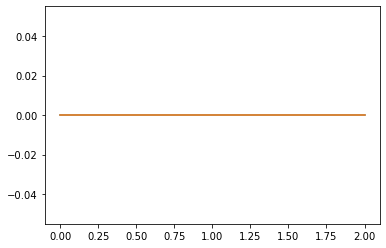

In [186]:
import matplotlib.pyplot as plt

# Train the model and store the training object
training = model.fit(train_data, train_labels, epochs=3, batch_size=10, validation_split = 0.2)

# Extract the history from the training object
history = training.history

# Plot the training loss 
plt.plot(history['loss'])
# Plot the validation loss
plt.plot(history['val_loss'])

# Show the figure
plt.show()

obviously this is bad!!!

In [191]:
!pwd

/Users/samhastings/Documents/coding/computer_vision/image_processing_keras


In [192]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets


In [194]:
from keras.models import load_model

# It can be used to reconstruct the model identically.
reconstructed_model = load_model("my_model")

# Predict from the first three images in the test data
reconstructed_model.predict(test_data[:3]) 

array([[1.],
       [1.],
       [1.]], dtype=float32)

## Interpreting the model

In [208]:
# Get the first convolutional layer from the model
c1 = reconstructed_model.layers[0]

# Get the weights of the first convolutional layer
weights1 = c1.get_weights()

# Pull out all channels of the first kernel in the first layer
kernel = weights1[0][:,:,:, 0]
print(kernel)

[[[ 0.14480941  0.1974004  -0.14246334]
  [ 0.2550754   0.2654563  -0.16115594]]

 [[ 0.28560776 -0.20862828 -0.07963641]
  [-0.05903264 -0.21015015  0.29985955]]]


In [226]:
def convolution(image, kernel):
    im_height, im_width, im_depth = image.shape
    conv = np.zeros(image.shape)

    for c in range(im_depth):
        for ii in range(im_height):
            for jj in range(im_depth):
                window=image[ii:ii+2, jj:jj+2, c]
                conv[ii,jj,c] = np.sum(window*kernel[:,:,c])
    return conv

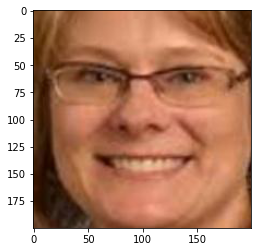

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


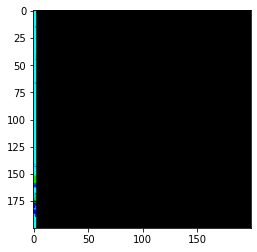

In [231]:
image = test_data[0]
conv = convolution(image, kernel)
show_cv2_image(image)
show_cv2_image(conv)